<a href="https://colab.research.google.com/github/SergioPGJunior/detecthypotension/blob/master/mit_bih_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wfdb
! pip install h5py
! pip install heartpy

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
from heartpy import filtering

In [ ]:
def load_ecg(file):
    # Leitura e armazenamento dos dados
    record = wfdb.rdrecord(file)

    # Leitura e armazenamento das anotações
    annotation = wfdb.rdann(file, "atr")

    #Extrai os sinais
    p_signal = record.p_signal

    #Verifica se a frequência é 360
    assert record.fs == 360, "Frequência de amostragem não é 360"

    #Extrai os símbolos e anotações
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [ ]:
def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
  # this function builds the X,Y matrices for each beat
  # it also returns the original symbols for Y

  num_rows = len(df_ann)
  X = np.zeros((num_rows, num_cols))
  Y = np.zeros((num_rows, 1))
  sym = []

  # keep track of rows
  max_row = 0
  for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
      left = max([0, (atr_sample - num_sec * fs)])
      right = min([len(p_signal), (atr_sample + num_sec * fs)])
      x = p_signal[left: right]
      if len(x) == num_cols:
          X[max_row, :] = x
          Y[max_row, :] = int(atr_sym in abnormal)
          sym.append(atr_sym)
          max_row += 1
  X = X[:max_row, :]
  Y = Y[:max_row, :]
  return X, Y, sym

In [ ]:
# Caminho onde os arquivos da base de dados estão armazenados
path = "/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0/"

# Cria um dataframe com os nomes dos arquivos
rec = pd.read_csv(path + "RECORDS", names="n", dtype=str)

# Lista de nonbeats e abnormal
nonbeat = ['[', '!', ']', 'x', '(', ')', 'p', 't', '`', 'u', '\\', '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@', 'Q', '?']
#abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']
abnormal = {'V', 'A'}

num_sec = 1
fs = 360
paciente_both = []
paciente_any = []
paciente_vpc = []
paciente_apc = []


for pt in rec.n:
  file = path + pt
  # Leitura e armazenamento das anotações
  annotation = wfdb.rdann(file, "atr")
  #Extrai os símbolos e anotações
  atr_sym = annotation.symbol
  atr_sample = annotation.sample

  atr_sym_set = set(atr_sym)

  if atr_sym_set.issuperset(abnormal):
    paciente_both.append(pt)

  if atr_sym_set.intersection(abnormal):
    paciente_any.append(pt)

  abnormal = list(abnormal)

  if abnormal[0] in atr_sym_set:
    paciente_vpc.append(pt)

  if abnormal[1] in atr_sym_set:
    paciente_apc.append(pt)

print("Número de pacientes com as duas arritmias: {}".format(len(paciente_both)))
print("Pacientes com as duas arritmias: {}".format(paciente_both))
print("Número de pacientes com pelo menos uma das arritmias: {}".format(len(paciente_any)))
print("Pacientes com pelo menos uma das arritmias: {}".format(paciente_any))
print("Número de pacientes com VPC: {}".format(len(paciente_vpc)))
print("Pacientes com VPC: {}".format(paciente_vpc))
print("Número de pacientes com APC: {}".format(len(paciente_apc)))
print("Pacientes com APC: {}".format(paciente_apc))

  

Número de pacientes com as duas arritmias: 20
Pacientes com as duas arritmias: ['100', '108', '114', '116', '118', '121', '124', '200', '201', '202', '205', '207', '209', '213', '215', '219', '223', '228', '231', '233']
Número de pacientes com pelo menos uma das arritmias: 44
Pacientes com pelo menos uma das arritmias: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '114', '116', '117', '118', '119', '121', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Número de pacientes com VPC: 37
Pacientes com VPC: ['100', '102', '104', '105', '106', '107', '108', '109', '111', '114', '116', '118', '119', '121', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '213', '214', '215', '217', '219', '221', '223', '228', '230', '231', '233', '234']
Número de pacientes com APC: 27
Pacientes com APC: ['100', 

In [ ]:
# Caminho onde os arquivos da base de dados estão armazenados
path = "/content/drive/My Drive/mit-bih-arrhythmia-database-1.0.0/"

# Cria um dataframe com os nomes dos arquivos
rec = pd.read_csv(path + "RECORDS", names="n", dtype=str)

# Lista de nonbeats e abnormal
nonbeat = ['[', '!', ']', 'x', '(', ')', 'p', 't', '`', 'u', '\\', '^', '|', '~', '+', 's', 'T', '*', 'D', '=', '"', '@', 'Q', '?']
#abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']
abnormal = ['V', 'A']

num_sec = 1
fs = 360

#Inicilaiza os vetores
num_cols = 2 * num_sec * fs #numero de colunas que vai armazenar um amostra 
X_all = np.zeros((1, num_cols)) #Cria um vetor com numero de elementos igual a num_cols e preenche com zeros 
Y_all = np.zeros((1, 1)) #cria um vetor com com um elemento e preenche com zero
sym_all = []

#Lista para controlar o número de batimentos de cada paciente
max_rows = []

for pt in rec.n:
  file = path + pt
  p_signal, atr_sym, atr_sample = load_ecg(file)
  
  if 'A' and 'V' in atr_sym:
    #Seleciona o sinal MLII
    p_signal = p_signal[:, 0]
    # p_signal = filtering.remove_baseline_wander(p_signal, fs, cutoff=0.05) # remove the baseline wandering

    # Cria um df para excluir o que mão é um batimento
    df_ann = pd.DataFrame({'atr_sym': atr_sym,
                          'atr_sample': atr_sample})
    df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]

    X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs)
    sym_all = sym_all + sym
    max_rows.append(X.shape[0])
    X_all = np.append(X_all, X, axis=0)
    Y_all = np.append(Y_all, Y, axis=0)

#Exclui a primeira linha que é formada por zeros
X_all = X_all[1:, :]
Y_all = Y_all[1:, :]

#Verifica se os tamanhos das matrizes fazem sentido
assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

d = {x:np.count_nonzero(Y_all == x) for x in [0,1]} #Calcula quantas amostras cada classe possui 0 -> Normal, 1 -> Arritmia

print(d)
print(len(X_all)) #Quantidade total de amostras


{0: 55820, 1: 7979}
63799


In [ ]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.3)

# create model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.001)))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid'))

# Compile model
opt = SGD(learning_rate=0.001)
#opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#Dado que o número de amostras de batimentos normais é 7 vezes maior do que anormais, foi utilizado o balancemaneto das classes
class_weight = {0: 1.,
                1: 7.}

# Fit the model
history = model.fit(X_all, Y_all, validation_split=0.3, epochs=500, batch_size=32, class_weight=class_weight, verbose=0, callbacks=[es, mc])
#history = model.fit(X_all, Y_all, validation_split=0.3, epochs=500, batch_size=32, verbose=0, callbacks=[es, mc])

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 00084: early stopping
Train: 0.986, Test: 0.986


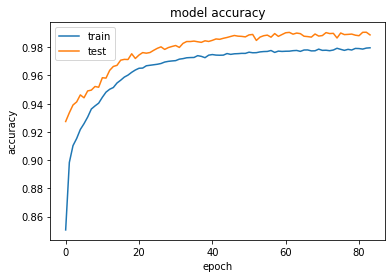

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

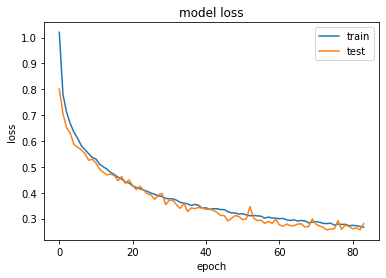

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)


# The predictions are returned in a two-dimensional array, with one row for each example in the test dataset and one column for the prediction.
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison, therefore, we must reduce the 2D prediction arrays to 1D arrays
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)



Accuracy: 0.986468
Precision: 0.941914
Recall: 0.949452
F1 score: 0.945668
Cohens kappa: 0.937940
ROC AUC: 0.994197
[[16627   139]
 [  120  2254]]
